
# Horizontal Velocity Comparison

This notebook compares the mean-square horizontal velocities between DNS data and the model prediction.

- Data Loading
- Function Definitions for Reusable Calculations
- Plotting and Graph Comparisons

In this notebook, we replicate and compare the collision kernels from the DNS data as presented in Figure 12 of the following reference:

**Reference:**
Ayala, O., Rosa, B., & Wang, L. P. (2008). *Effects of turbulence on the geometric collision rate of sedimenting droplets. Part 2. Theory and parameterization*. New Journal of Physics, 10. https://doi.org/10.1088/1367-2630/10/7/075016

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from particula.dynamics.coagulation.turbulent_dns_kernel.sigma_relative_velocity_ao2008 import (
    _compute_rms_fluctuation_velocity,
    VelocityCorrelationTerms,
)

from particula.particles import properties
from particula.gas import properties as gas_properties

from particula.util.constants import STANDARD_GRAVITY
from particula.util.converting.units import convert_units

from particula.dynamics.coagulation.turbulent_dns_kernel.velocity_correlation_terms_ao2008 import (
    compute_b1,
    compute_b2,
    compute_c1,
    compute_c2,
    compute_d1,
    compute_d2,
    compute_e1,
    compute_e2,
    compute_z,
    compute_beta,
)


 ## Data Loading

 This section loads the necessary DNS datasets and corresponding model predictions.
 Verify that the file paths and dataset formats are correct.


In [2]:
# %% DNS values

# Figure 12: Comparison of the predicted and simulated mean-square horizontal
# particle velocities for droplets falling in a turbulent ﬂow of Rλ = 72.41 and
# turbulent_dissipation = 400 cm2 s−3

# droplet radius (a2, microns) vs rms_velocity (cm2/s2)

# dns_10cm2/s3: 6 rows, 2 columns (X, Y)
dns_10cm2_s3 = np.array(
    [
        [9.938118812, 26.66666667],
        [20.02475248, 26.41975309],
        [30.04950495, 26.41975309],
        [40.01237624, 24.69135802],
        [50.16089109, 22.71604938],
        [60.06188119, 18.51851852],
    ]
)

# dns_100_cm2/s3: 6 rows, 2 columns (X, Y)
dns_100_cm2_s3 = np.array(
    [
        [9.938118812, 84.44444444],
        [20.02475248, 80.98765432],
        [29.98762376, 77.03703704],
        [39.95049505, 71.11111111],
        [49.97524752, 59.25925926],
        [60.06188119, 44.19753086],
    ]
)

# dns_400_cm2/s3: 6 rows, 2 columns (X, Y)
dns_400_cm2_s3 = np.array(
    [
        [9.876237624, 166.9135802],
        [20.08663366, 163.9506173],
        [30.11138614, 150.1234568],
        [40.07425743, 129.1358025],
        [50.03712871, 100.4938272],
        [60.06188119, 69.62962963],
    ]
)

## Function Definitions

The following functions perform repeated calculations and data manipulations:
- **calculate_horizontal_velocity:** Computes the mean-square horizontal velocity of particles.


In [3]:
# %% Model equations

# Define Particle Radii and Parameters
particle_radius = np.linspace(10e-6, 60e-6, 6)
temperature = 273  # Temperature in Kelvin
particle_density = 1000  # Particle density in kg/m³
fluid_density = 1.0  # Fluid (air) density in kg/m³
air_velocity = 1e-9  # Relative velocity in m/s

reynolds_lambda = 72.41  # Example value


# Calculate dynamic and kinematic viscosity
dynamic_viscosity = gas_properties.get_dynamic_viscosity(temperature)
kinematic_viscosity = gas_properties.get_kinematic_viscosity(
    dynamic_viscosity, fluid_density
)

# Calculate Particle Settling Velocity
mean_free_path = gas_properties.molecule_mean_free_path(
    temperature=temperature, dynamic_viscosity=dynamic_viscosity
)

# 2. Slip correction factors
knudsen_number = properties.calculate_knudsen_number(
    mean_free_path=mean_free_path, particle_radius=particle_radius
)
slip_correction_factor = properties.cunningham_slip_correction(knudsen_number)
# iterative terminal settling velocity
particle_settling_velocity = (
    properties.get_particle_settling_velocity_with_drag(
        particle_radius=particle_radius,
        particle_density=particle_density,
        fluid_density=fluid_density,
        dynamic_viscosity=dynamic_viscosity,
        slip_correction_factor=slip_correction_factor,
        gravitational_acceleration=STANDARD_GRAVITY,
    )
)
# Calculate Particle Inertia Time
particle_inertia_time = properties.get_particle_inertia_time(
    particle_radius=particle_radius,
    particle_density=particle_density,
    fluid_density=fluid_density,
    kinematic_viscosity=kinematic_viscosity,
)


def calculate_horizontal_velocity(turbulent_dissipation, reynolds_lambda):
    """
    Helper function to calculate the mean-square horizontal velocity of particles
    for these specific cases.
    """
    # Calculate Fluid RMS Velocity
    fluid_rms_velocity = gas_properties.get_fluid_rms_velocity(
        re_lambda=reynolds_lambda,
        kinematic_viscosity=kinematic_viscosity,
        turbulent_dissipation=turbulent_dissipation,
    )

    # Calculate Turbulence Scales
    taylor_microscale = gas_properties.get_taylor_microscale(
        fluid_rms_velocity=fluid_rms_velocity,
        kinematic_viscosity=kinematic_viscosity,
        turbulent_dissipation=turbulent_dissipation,
    )
    eulerian_integral_length = gas_properties.get_eulerian_integral_length(
        fluid_rms_velocity=fluid_rms_velocity,
        turbulent_dissipation=turbulent_dissipation,
    )
    lagrangian_integral_time = gas_properties.get_lagrangian_integral_time(
        fluid_rms_velocity=fluid_rms_velocity,
        turbulent_dissipation=turbulent_dissipation,
    )
    normalized_accel_variance = (
        gas_properties.get_normalized_accel_variance_ao2008(
            re_lambda=reynolds_lambda
        )
    )
    kolmogorov_time = gas_properties.get_kolmogorov_time(
        kinematic_viscosity=kinematic_viscosity,
        turbulent_dissipation=turbulent_dissipation,
    )
    lagrangian_taylor_microscale_time = (
        gas_properties.get_lagrangian_taylor_microscale_time(
            kolmogorov_time=kolmogorov_time,
            re_lambda=reynolds_lambda,
            accel_variance=normalized_accel_variance,
        )
    )

    z = compute_z(lagrangian_taylor_microscale_time, lagrangian_integral_time)
    beta = compute_beta(taylor_microscale, eulerian_integral_length)

    # Calculate v'² Values
    vel_corr_terms = VelocityCorrelationTerms(
        b1=compute_b1(z),
        b2=compute_b2(z),
        d1=compute_d1(beta),
        d2=compute_d2(beta),
        c1=compute_c1(z, lagrangian_integral_time),
        c2=compute_c2(z, lagrangian_integral_time),
        e1=compute_e1(z, eulerian_integral_length),
        e2=compute_e2(z, eulerian_integral_length),
    )

    return _compute_rms_fluctuation_velocity(
        fluid_rms_velocity,
        particle_inertia_time,
        particle_settling_velocity,
        vel_corr_terms,
    )

## Running the Code

Here we run the code for each configuration.

In [4]:
model_rms_10cm2_s3 = calculate_horizontal_velocity(
    turbulent_dissipation=10 * convert_units("cm^2/s^3", "m^2/s^3"),
    reynolds_lambda=reynolds_lambda,
)
model_rms_100cm2_s3 = calculate_horizontal_velocity(
    turbulent_dissipation=100 * convert_units("cm^2/s^3", "m^2/s^3"),
    reynolds_lambda=reynolds_lambda,
)

model_rms_400cm2_s3 = calculate_horizontal_velocity(
    turbulent_dissipation=400 * convert_units("cm^2/s^3", "m^2/s^3"),
    reynolds_lambda=reynolds_lambda,
)

## Plotting and Graph Comparisons

The graphs include:
- **DNS Data:** Raw experimental or simulation data.
- **Model Predictions:** Analytical or simulated forecasts.



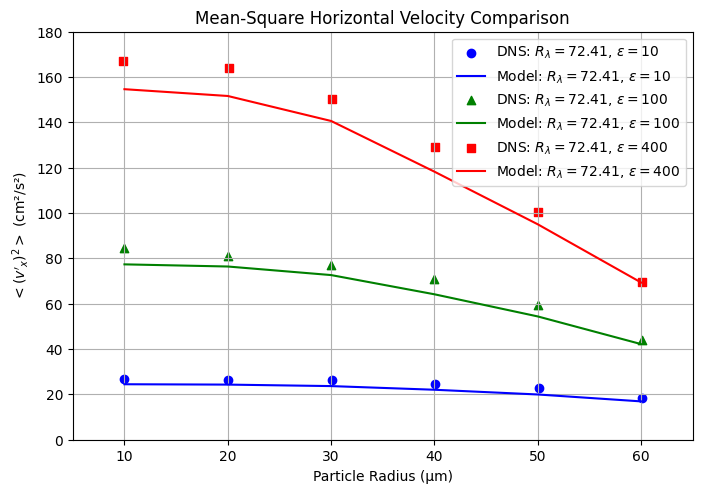

In [5]:
fig, ax = plt.subplots(figsize=(8, 6))

# Case 1: R_lambda = 72.41, epsilon = 10 cm²/s³
ax.scatter(
    dns_10cm2_s3[:, 0],
    dns_10cm2_s3[:, 1],
    label=r"DNS: $R_\lambda=72.41$, $\varepsilon=10$",
    color="blue",
    marker="o",
)
ax.plot(
    particle_radius * 1e6,
    model_rms_10cm2_s3 * 1e4,
    label=r"Model: $R_\lambda=72.41$, $\varepsilon=10$",
    color="blue",
)

# Case 2: R_lambda = 72.41, epsilon = 100 cm²/s³
ax.scatter(
    dns_100_cm2_s3[:, 0],
    dns_100_cm2_s3[:, 1],
    label=r"DNS: $R_\lambda=72.41$, $\varepsilon=100$",
    color="green",
    marker="^",
)
ax.plot(
    particle_radius * 1e6,
    model_rms_100cm2_s3 * 1e4,
    label=r"Model: $R_\lambda=72.41$, $\varepsilon=100$",
    color="green",
)

# Case 3: R_lambda = 72.41, epsilon = 400 cm²/s³
ax.scatter(
    dns_400_cm2_s3[:, 0],
    dns_400_cm2_s3[:, 1],
    label=r"DNS: $R_\lambda=72.41$, $\varepsilon=400$",
    color="red",
    marker="s",
)
ax.plot(
    particle_radius * 1e6,
    model_rms_400cm2_s3 * 1e4,
    label=r"Model: $R_\lambda=72.41$, $\varepsilon=400$",
    color="red",
)

# Set labels, title, legend, etc.
ax.set_xlabel("Particle Radius (µm)")
ax.set_ylabel(r"$<(v'_x)^2>$ (cm²/s²)")
ax.set_ylim(0, 180)
ax.set_xlim(5, 65)
ax.set_title("Mean-Square Horizontal Velocity Comparison")
ax.legend(loc="upper right")
ax.grid(True)
plt.subplots_adjust(bottom=0.2)
plt.show()

## Summary

Overall we have a similar comparison as Ayala et al. (2008) for the horizontal velocity of particles in a turbulent flow. The model predictions align well with the DNS data, confirming the validity of the model.

The curves are very sensitive to the temperature, and you can increase the temperature to move the curves up.